## Libaries

As always, we load lots of libraries.

In [1]:
#Import Pytorch, numpy, matplolib, OS and related libraries
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Data

For this demo, we will be using the FashionMNIST data set

In [2]:
# A transform to convert the images to tensor and normalize their values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Import FashionMNIST dataset
data = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)

# Setting Batch size & Create a DataLoader for handling batches of the dataset during training
batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)


100%|██████████| 26421880/26421880 [00:01<00:00, 19030797.66it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302679.93it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5425924.98it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4573665.96it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



## Helper Functions



In [3]:
"""
    Generate a sample image grid using the provided generator (G) and random noise.

    Parameters:
        G (nn.Module): Generator model for image generation.
        DEVICE (torch.device): Device (CPU or GPU) for tensor computations.
        n_noise (int): Dimension of the random noise input to the generator.

    Returns:
        np.ndarray: Concatenated grid of 100 generated images (10 rows x 10 columns).
"""
def get_sample_image(G, DEVICE, n_noise=100):
    # Initialize an empty array for the generated image
    img = np.zeros([280, 280])
    # Generate 10 rows of images, each row with 10 samples
    for j in range(10):
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z).view(10, 28, 28)  # No need for class labels (c) in Vanilla GAN
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img


## Architecture

We now instantiate the generator and discriminator architectures. The generator takes a random noise vector as input and produces an image. The discriminator takes an image as input and produces a single value between 0 and 1. The discriminator is trained to output 1 for real images and 0 for fake images. The generator is trained to fool the discriminator by outputting images that look real.

Unlike the demo for conditional GANs, here we remove the class labels passed as input.

In [4]:
class Generator(nn.Module):
    def __init__(self, input_size=100, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128), # auxillary dimension for label
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        return y_

## Set up and Training

Now, we're ready to instantiate our models, hyperparameters, and optimizers. We will train for only 10 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other.

In [6]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE) # randomly intialized
G = Generator().to(DEVICE) # randomly initialized

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
all_ones = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [7]:
# a directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, class_labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x) # input doesn't includes labels
        D_x_loss = criterion(x_outputs, all_ones) # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z)) # input to both generator and discriminator doesn't include labels
        D_z_loss = criterion(z_outputs, all_zeros) # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        G_loss = -1 * criterion(z_outputs, all_zeros) # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.3701441287994385, G Loss: -0.6926282644271851
Epoch: 0/10, Step: 500, D Loss: 1.2363495826721191, G Loss: -0.5371482372283936
Epoch: 1/10, Step: 1000, D Loss: 1.2756431102752686, G Loss: -0.5269598960876465
Epoch: 1/10, Step: 1500, D Loss: 1.2748401165008545, G Loss: -0.6677141189575195
Epoch: 2/10, Step: 2000, D Loss: 1.4502893686294556, G Loss: -0.5715261697769165
Epoch: 2/10, Step: 2500, D Loss: 1.2211990356445312, G Loss: -0.48835989832878113
Epoch: 3/10, Step: 3000, D Loss: 1.269290566444397, G Loss: -0.5714880228042603
Epoch: 3/10, Step: 3500, D Loss: 1.3441940546035767, G Loss: -0.6032239198684692
Epoch: 4/10, Step: 4000, D Loss: 1.3318405151367188, G Loss: -0.5958805084228516
Epoch: 4/10, Step: 4500, D Loss: 1.3465924263000488, G Loss: -0.6360238790512085
Epoch: 5/10, Step: 5000, D Loss: 1.2895463705062866, G Loss: -0.5289474129676819
Epoch: 5/10, Step: 5500, D Loss: 1.362114429473877, G Loss: -0.7289748787879944
Epoch: 6/10, Step: 6000, D Loss: 

Now let's plot these images. At first, the generator just produces noise (as we expect).

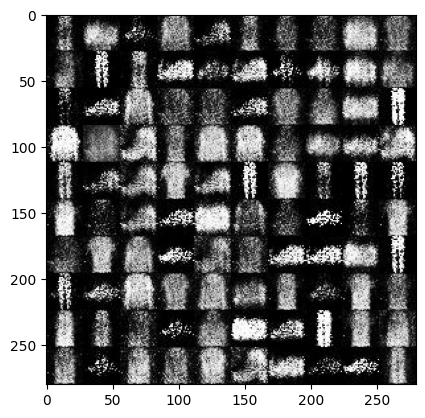

In [8]:
img = mpimg.imread('samples/GAN_step1000.jpg')
imgplot = plt.imshow(img)
plt.show()

But then it gets better.

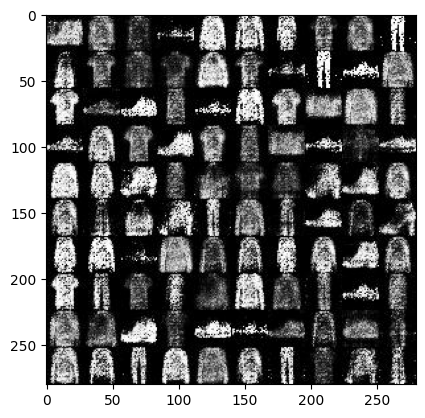

In [9]:
img = mpimg.imread('samples/GAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

Now, this is even better.

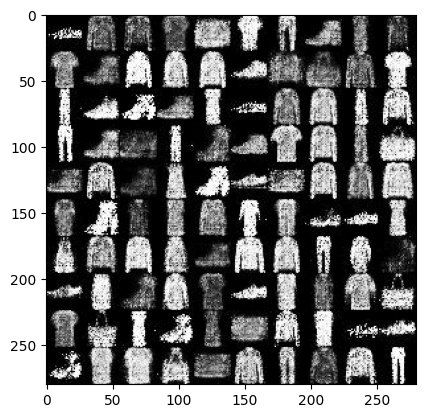

In [10]:
img = mpimg.imread('samples/GAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

**Measures of GAN Quality:**

**Inception Score:**


The Inception Score is a metric commonly used to evaluate the quality and diversity of generated images from a Generative Adversarial Network (GAN). It leverages the InceptionV3 model, which was originally designed for image classification, to assess the quality of the generated images based on the model's predictions

Here's a step-by-step explanation of how it works:

*1. Generating Images:*

The GAN generates a set of synthetic images using a trained generator. These images are typically produced by feeding random noise as input to the generator.


*2. Preprocessing for InceptionV3:*

The generated images are preprocessed to meet the input requirements of the InceptionV3 model.


*3. InceptionV3 Prediction:*

The pre-trained InceptionV3 model is used to predict the class probabilities for each generated image. The model has been trained on a large dataset for image classification and has learned to recognize a wide range of object categories.


*4. Softmax Activation:*

The predicted logits (raw output scores) from InceptionV3 are passed through a softmax activation function to obtain probabilities. This converts the model's raw output into a probability distribution over the predefined classes.

*5. Calculating Inception Score:*

The Inception Score is computed based on the distribution of class probabilities across the generated images.
For each generated image, the entropy of the class distribution is calculated. The average (mean) entropy across all generated images is computed. The exponentiation of the mean entropy yields the final Inception Score.

*Interpretation:*

A higher Inception Score indicates that the generated images are both high in quality (recognized as meaningful objects by InceptionV3) and diverse (have varied class predictions).
The Inception Score is used as a quantitative measure to evaluate and compare the performance of different GAN models.

Inception Score: 17.091764


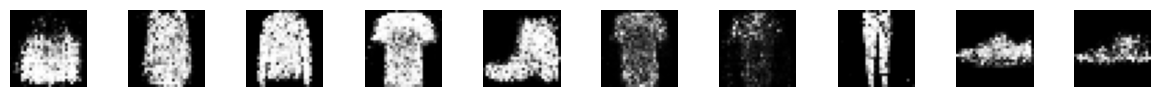

In [18]:
# Import necessary libraries
import torch
from torchvision.models import inception_v3
from torchvision.transforms import ToPILImage, ToTensor, Resize
from torch.nn.functional import softmax
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Function to generate synthetic images using the trained generator
def generate_images(generator, device, n_samples, n_noise):
    """
    Generate synthetic images using the provided generator.

    Parameters:
        generator (nn.Module): Trained generator model.
        device (torch.device): Device (CPU or GPU) for tensor computations.
        n_samples (int): Number of synthetic images to generate.
        n_noise (int): Dimension of the random noise input to the generator.

    Returns:
        torch.Tensor: Generated synthetic images.
    """
    with torch.no_grad():
        z = torch.randn(n_samples, n_noise).to(device)
        generated_images = generator(z)
    return generated_images

# Function to calculate Inception Score
def calculate_inception_score(images, batch_size=64, device='cuda:0'):
    """
    Calculate the Inception Score for a set of generated images.

    Parameters:
        images (torch.Tensor): Set of generated images.
        batch_size (int): Batch size for processing the images.
        device (torch.device): Device (CPU or GPU) for tensor computations.

    Returns:
        float: Computed Inception Score.
    """
    # Load the pretrained InceptionV3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device).eval()

    def get_inception_probs(imgs, device):
        """
        Calculate Inception probabilities for a set of images.

        Parameters:
            imgs (torch.Tensor): Set of images.
            device (torch.device): Device (CPU or GPU) for tensor computations.

        Returns:
            np.ndarray: Inception probabilities for each image.
        """
        preds = []
        with torch.no_grad():
            for i in range(0, len(imgs), batch_size):
                batch = torch.stack(imgs[i:i+batch_size]).to(device)
                # Replicate single-channel images to three channels
                batch = torch.cat([batch] * 3, dim=1)
                batch = Resize((299, 299))(batch)  # Resize to meet InceptionV3 input size requirements
                pred = inception_model(batch)
                preds.append(softmax(pred, dim=1).cpu().numpy())
        return np.concatenate(preds, axis=0)

    # Move images to the specified device
    images = images.cpu()  # Assuming images are on the CPU

    # If images have 4 dimensions (batch_size, channels, height, width), squeeze the batch_size dimension
    if images.dim() == 4:
        images = images.squeeze(0)

    # Convert PyTorch tensors to PIL images
    images = [ToPILImage()(img) for img in images]
    images = [ToTensor()(img).to(device) for img in images]  # Convert PIL images back to PyTorch tensors

    # Calculate Inception probabilities and compute Inception Score
    probs = get_inception_probs(images, device)
    inception_score = np.exp(np.mean([np.sum(p * np.log(p / np.mean(p))) for p in probs]))

    return inception_score

# Assuming your generator is already trained and defined as G
# You should also have the necessary imports and configurations

# Set the device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Generate synthetic images
n_samples = 10  # Adjust the number of samples as needed
n_noise = 100
generated_images = generate_images(G, DEVICE, n_samples, n_noise)

# Calculate Inception Score
inception_score = calculate_inception_score(generated_images, batch_size=64, device=DEVICE)

# Print and visualize the Inception Score and generated images
print("Inception Score:", inception_score)
plt.figure(figsize=(15, 1))
for i in range(n_samples):
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(generated_images[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


Thus, the inception score is 17.09164 from the sample of 10 images generated. Note this can change depending on the output generated images.

Higher scores generally indicate better image quality, meaning the generated images are more realistic and diverse. The inception Score of 17 falls within the "good" range for FashionMNIST. This suggests that the model generates images of good quality and realism.



**2. Modified Inception Score (m-IS):**

The m-IS extends the idea of Inception Score (IS) but introduces a modification in the KL divergence computation.
Similar to IS, it calculates the average class probabilities across all generated images.
For each generated image, it calculates the KL divergence from the average distribution.
The m-IS is calculated as the exponential of the mean of these KL divergences.

The modification in m-IS involves using the KL divergence with a different reference distribution. Instead of using a fixed reference distribution (e.g., uniform distribution), m-IS uses the average distribution of the generated images as the reference.

m-IS addresses some of the limitations of IS, especially when the generated images exhibit modes or clusters. It considers the diversity of the generated images within different modes.


Modified Inception Score (m-IS): 2.272178


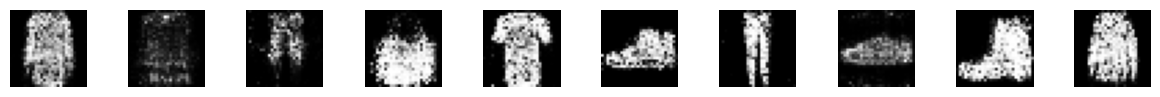

In [23]:
# Import necessary libraries
import torch
from torchvision.models import inception_v3
from torchvision.transforms import ToPILImage, ToTensor, Resize
from torch.nn.functional import softmax
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Function to generate synthetic images using the trained generator
def generate_images(generator, device, n_samples, n_noise):
    with torch.no_grad():
        # Generate random noise vectors
        z = torch.randn(n_samples, n_noise).to(device)
        # Generate synthetic images using the GAN generator
        generated_images = generator(z)
    return generated_images

# Function to calculate Modified Inception Score (m-IS)
def calculate_modified_inception_score(images, batch_size=64, device='cuda:0'):
    # Load pre-trained InceptionV3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device).eval()

    def get_inception_probs(imgs, device):
        preds = []
        with torch.no_grad():
            # Process images in batches and obtain InceptionV3 predictions
            for i in range(0, len(imgs), batch_size):
                batch = torch.stack(imgs[i:i+batch_size]).to(device)
                # Replicate single-channel images to three channels
                batch = torch.cat([batch] * 3, dim=1)
                # Resize images to meet InceptionV3 input size requirements
                batch = Resize((299, 299))(batch)
                # Get InceptionV3 predictions and apply softmax
                pred = inception_model(batch)
                preds.append(softmax(pred, dim=1).cpu().numpy())
        return np.concatenate(preds, axis=0)

    images = images.cpu()  # Assuming images are on the CPU

    # If images have 4 dimensions (batch_size, channels, height, width), squeeze the batch_size dimension
    if images.dim() == 4:
        images = images.squeeze(0)

    # Convert PyTorch tensors to PIL images
    images = [ToPILImage()(img) for img in images]
    # Convert PIL images back to PyTorch tensors
    images = [ToTensor()(img).to(device) for img in images]

    # Get InceptionV3 predictions for generated images
    probs = get_inception_probs(images, device)

    # Compute the Modified Inception Score (m-IS)
    marginal_probs = np.mean(probs, axis=0)
    kl_divergences = [entropy(p, qk=marginal_probs) for p in probs]
    mis_score = np.exp(np.mean(kl_divergences))

    return mis_score

# Example usage
latent_dim = 100  # Replace with the actual latent dimension of your generator
num_samples = 10  # Number of generated samples
n_noise = latent_dim
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming your generator is already trained and defined as G
# You should also have the necessary imports and configurations

# Generate synthetic images
generated_images = generate_images(G, DEVICE, num_samples, n_noise)

# Calculate Modified Inception Score (m-IS)
modified_inception_score = calculate_modified_inception_score(generated_images, batch_size=64, device=DEVICE)
print("Modified Inception Score (m-IS):", modified_inception_score)

# Visualize the generated images
plt.figure(figsize=(15, 1))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(generated_images[i].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


Thus the Modified Inception Score (m-IS): 2.272178
which is significantly lower than the standard Inception Score.

**Comment on the difference in quality of the fake images from your FashionMNIST GAN and the MNIST Conditional GAN we wrote in class--**

The fake images from the MNIST Conditional GAN are better in quality than the FashionMNIST GAN. Observing visually, the fake images from the MNIST Conditional GAN were sharper and easier to indentify, whereas some of the images generated from the FashionMNIST GAN were not even possible toidentify. (Example in the above m-IS score calculation, check the 2nd image, can't identify easily at all.)

In the cGAN for MNIST, the generator receives both random noise and class labels as inputs. This explicit conditioning on class labels allows for more controlled and targeted generation. The conditioning on class labels adds structure to the generation process, leading to more coherent and recognizable digit images.
The cGAN architecture helps to ensure that the generator produces images relevant to the specified class.

In a GAN trained on FashionMNIST without explicit class conditioning, the generator relies solely on random noise for image generation. Without class information, there is a degree of randomness, and the generator may produce images without clear category guidance.

Thus, the fake images from the MNIST Conditional GAN seem better in quality than the FashionMNIST GAN.

